<a href="https://colab.research.google.com/github/Toandinh1/DeepIM/blob/master/414PSK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
%tensorflow_version 1.5

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.5`. This will be interpreted as: `1.x`.


After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow is already loaded. Please restart the runtime to change versions.


In [67]:
import numpy as np
import tensorflow as tf
from scipy.special import binom
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Conv1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.python.ops.gen_math_ops import sign
#from keras import backend as K




N = 4 # number of sub-carriers
K = 1 # number of active sub-carriers
M = 4 # M-ary modulation order

SNRdb = 7 # Training SNR

traing_epochs = 100
l_rate = 0.01
total_batch = 20 # number of batches per epoch
batch_size = 100


n_output_1 = 16
n_output_2 = 32
n_input_1 = N
n_input_2 = 2*N


m = int(np.log2(M))
c = int(np.log2(binom(N,K)))
q = K*m + c # number of bits per OFDM-IM symbol
Q= 2**q
n_output = c

c1 = 4
c2 = 1

SNR = 10**(SNRdb/10)
sigma = np.sqrt(1/SNR)

display_step = 5
qam_factor = (2/3)*(M-1)


a = 1/np.sqrt(2)

# M-ary modulations
if M==4:
    QAM = np.array([1+0j, 0+1j, -0-1j, -1+0j], dtype=complex) # gray mapping
elif M==8:
    QAM = np.array([1, a+a*1j, -a+a*1j, 1j, a-a*1j, -1j, -1, -a-a*1j], dtype=complex) # 8PSK, not 8QAM indeed
    qam_factor = 1
elif M==16:
    QAM = np.array([-3+3j, -3+1j, -3-3j, -3-1j, 
                    -1+3j, -1+1j, -1-3j, -1-1j, 
                    3+3j, 3+1j, 3-3j, 3-1j, 
                    1+3j, 1+1j, 1-3j, 1-1j], dtype=complex)
else:
    QAM = np.array([1,-1], dtype=complex) #BPSK
    qam_factor = 1


# index patterns for N=4 and K=1,2,3 only
if K==1:
    idx = np.array([[0],[1],[2],[3]])
elif K==2:
    idx = np.array([[0,1],[2,3],[0,2],[1,3]]) 
else:
    idx = np.array([[0,1,2],[1,2,3],[0,2,3],[0,1,3]]) 
def SC_IM_NO_train(bit1,bit2, SNRdb):
        #user1
    bit_id1 = bit1[0:c:1]
    id_de1 = bit_id1.dot(2**np.arange(bit_id1.size)[::-1])
    bit_sy1 = bit1[c:q:1]   
    bit_K1 = bit_sy1.reshape(-1,m)
    sy_de1 = np.zeros((K,), dtype=int)
    sym1 = np.zeros((K,), dtype=complex)
    for i in range(K):
        bit_sy_i1 = bit_K1[i,:]
        sy_de1[i] = bit_sy_i1.dot(2**np.arange(bit_sy_i1.size)[::-1])
        sym1[i] = QAM[sy_de1[i]]

    tx_sym1 = np.zeros((N,), dtype=complex)
    tx_sym1[idx[id_de1,:]] = sym1
    tx_sym1 = tx_sym1*np.sqrt(c1)
  #user2
    bit_id2 = bit2[0:c:1]
    id_de2 = bit_id2.dot(2**np.arange(bit_id2.size)[::-1])
    bit_sy2 = bit2[c:q:1]   
    bit_K2 = bit_sy2.reshape(-1,m)
    sy_de2 = np.zeros((K,), dtype=int)
    sym2 = np.zeros((K,), dtype=complex)
    for i in range(K):
        bit_sy_i2 = bit_K2[i,:]
        sy_de2[i] = bit_sy_i2.dot(2**np.arange(bit_sy_i2.size)[::-1])
        sym2[i] = QAM[sy_de2[i]]

    tx_sym2 = np.zeros((N,), dtype=complex)
    tx_sym2[idx[id_de2,:]] = sym2
    tx_sym2 = tx_sym2*np.sqrt(c2)

    #transmision
    SNR = 10**(SNRdb/10)
    sigma = np.sqrt(1/SNR)
    noise = sigma*np.sqrt(1/2)*(np.random.randn(*tx_sym1.shape)+1j*np.random.randn(*tx_sym1.shape))
    #noise = np.random.normal(0, 1, tx_sym1.shape)
    H1 = 1
    H2 = 1
    
    y = H1*tx_sym1 + H2*tx_sym2 + noise
     
    y_bar = y/ H1
    y_con = np.concatenate((np.real(y_bar),np.imag(y_bar)))
    y_m = np.absolute(y_bar)
    Y =np.concatenate((y_con,y_m))
    
    return Y,y_con
    
  
    

def SC_IM_NO_test(bit1, bit2, SNRdb):
        #user1
    bit_id1 = bit1[0:c:1]
    id_de1 = bit_id1.dot(2**np.arange(bit_id1.size)[::-1])
    bit_sy1 = bit1[c:q:1]   
    bit_K1 = bit_sy1.reshape(-1,m)
    sy_de1 = np.zeros((K,), dtype=int)
    sym1 = np.zeros((K,), dtype=complex)
    for i in range(K):
        bit_sy_i1 = bit_K1[i,:]
        sy_de1[i] = bit_sy_i1.dot(2**np.arange(bit_sy_i1.size)[::-1])
        sym1[i] = QAM[sy_de1[i]]

    tx_sym1 = np.zeros((N,), dtype=complex)
    tx_sym1[idx[id_de1,:]] = sym1
    tx_sym1 = tx_sym1*np.sqrt(c1)
  #user2
    bit_id2 = bit2[0:c:1]
    id_de2 = bit_id2.dot(2**np.arange(bit_id2.size)[::-1])
    bit_sy2 = bit2[c:q:1]   
    bit_K2 = bit_sy2.reshape(-1,m)
    sy_de2 = np.zeros((K,), dtype=int)
    sym2 = np.zeros((K,), dtype=complex)
    for i in range(K):
        bit_sy_i2 = bit_K2[i,:]
        sy_de2[i] = bit_sy_i2.dot(2**np.arange(bit_sy_i2.size)[::-1])
        sym2[i] = QAM[sy_de2[i]]

    tx_sym2 = np.zeros((N,), dtype=complex)
    tx_sym2[idx[id_de2,:]] = sym2
    tx_sym2 = tx_sym2*np.sqrt(c2)

    #transmision
    SNR = 10**(SNRdb/10)
    sigma = np.sqrt(1/SNR)
    noise = sigma*np.sqrt(1/2)*(np.random.randn(*tx_sym1.shape)+1j*np.random.randn(*tx_sym1.shape))
    H1 = 1
    H2 = 1
    
    y = H1*tx_sym1 + H2*tx_sym2 + noise
     
    y_bar = y / H1
    y_con = np.concatenate((np.real(y_bar),np.imag(y_bar)))
    y_m = np.absolute(y_bar)
    Y =np.concatenate((y_con,y_m))
    
    return Y,y_con
    



In [68]:
X = tf.placeholder("float", [None, 12])
Y = tf.placeholder("float", [None, 4])
initializer = tf.contrib.layers.xavier_initializer()

def encoder(x):
    weights = {                    
        'encoder_h1': tf.Variable(initializer([12, 64])),
        'encoder_h2': tf.Variable(initializer([64,128])),
        'encoder_h3': tf.Variable(initializer([128, 4])), 
                   
    }
    biases = {            
        'encoder_b1': tf.Variable(initializer([64])),
        'encoder_b2': tf.Variable(initializer([128])),
        'encoder_b3': tf.Variable(initializer([4])),           
    
    }
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']), biases['encoder_b3']))
    return layer_3

y_pred = encoder(X)
y_true = Y

cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
learning_rate = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
init = tf.global_variables_initializer()

Epoch: 0001 cost= 0.066429118
Epoch: 0006 cost= 0.018340392
Epoch: 0011 cost= 0.013748059
Epoch: 0016 cost= 0.013603597
Epoch: 0021 cost= 0.016281282
Epoch: 0026 cost= 0.013988871
Epoch: 0031 cost= 0.013863825
Epoch: 0036 cost= 0.012957069
Epoch: 0041 cost= 0.010043406
Epoch: 0046 cost= 0.012157285
Epoch: 0051 cost= 0.010869080
Epoch: 0056 cost= 0.009726768
Epoch: 0061 cost= 0.011880144
Epoch: 0066 cost= 0.011766620
Epoch: 0071 cost= 0.011416329
Epoch: 0076 cost= 0.008826246
Epoch: 0081 cost= 0.009459090
Epoch: 0086 cost= 0.010356951
Epoch: 0091 cost= 0.010366827
Epoch: 0096 cost= 0.009600200
SNR= 0 BER: 0.14050001
SNR= 3 BER: 0.061074972
SNR= 6 BER: 0.01897502
SNR= 9 BER: 0.003125012
SNR= 12 BER: 5.0008297e-05
SNR= 15 BER: 0.0
SNR= 18 BER: 0.0


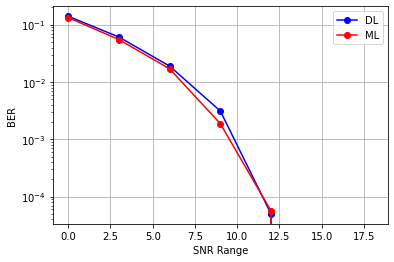

In [57]:
def frange(x,y,jump):
    while x < y:
        yield x
        x +=jump

EbNodB_range = list(frange(0,21,3))
BER1 = [None]*len(EbNodB_range)


with tf.Session() as sess:
  #Training
    sess.run(init)
    for epoch in range(traing_epochs):
        avg_cost = 0
        for index_m in range(total_batch):
            input_samples = []
            input_samples1 = []
            input_labels = []
            
            for index_k in range(0, batch_size):
                bits1 = np.random.binomial(n=1,p=0.5,size=(q,))
                bits2 = np.random.binomial(n=1,p=0.5,size=(q,))
                signaloutput = SC_IM_NO_train(bits1,bits2,7)
                input_labels.append(bits1)
                input_samples.append(signaloutput)
                
               

            batch_x = np.asarray(input_samples)
            batch_xx = np.asarray(input_samples1)
            batch_y = np.asarray(input_labels)
           
            
            

            _,cs = sess.run([optimizer,cost], feed_dict={X:batch_x,
                                                        Y:batch_y,
                                                        learning_rate:l_rate})
            avg_cost += cs / total_batch
        if epoch % display_step == 0:
            print("Epoch:",'%04d' % (epoch+1), "cost=", \
               "{:.9f}".format(avg_cost))
  #==========Testing=============
    for n in range(0,len(EbNodB_range)):
      input_samples_test = []
      input_samples1_test = []
      input_labels_test = []
      test_number = 10000
      if n>3:
        test_number = 10000
      for i in range(0, test_number):
        bits1 = np.random.binomial(n=1, p=0.5, size=(q, )) 
        bits2 = np.random.binomial(n=1, p=0.5, size=(q, ))
        signaloutput = SC_IM_NO_train(bits1,bits2,EbNodB_range[n])
        input_labels_test.append(bits1)
        input_samples_test.append(signaloutput)
        
               

      batch_x = np.asarray(input_samples_test)
      batch_y = np.asarray(input_labels_test)
      
      mean_error_rate = 1-tf.reduce_mean(tf.reduce_mean(tf.to_float(tf.equal(tf.sign(y_pred-0.5), tf.cast(tf.sign(batch_y-0.5),tf.float32))),1))
      BER1[n]  = mean_error_rate.eval({X:batch_x})
      print("SNR=", EbNodB_range[n], "BER:", BER1[n])
    ML1=[0.133100000000000,	0.0551562500000000,	0.0170187500000000,	0.00188125000000000,	5.62500000000000e-05,	0,	0]
    import matplotlib.pyplot as plt
    plt.plot(EbNodB_range, BER1, 'bo-',label='DL')
    plt.plot(EbNodB_range, ML1, 'ro-',label='ML')
    #plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
    plt.yscale('log')
    plt.xlabel('SNR Range')
    plt.ylabel('BER')
    plt.grid()
    plt.legend(loc='upper right',ncol = 1)
    #plt.savefig('DL_Detection_IM_BER_matplotlib')
    plt.show()

In [78]:
X = tf.placeholder("float",[None, 12])
Xa= tf.placeholder("float",[None, 8])
y_pred = encoder(X)
X1 = tf.concat((y_pred,Xa),axis=-1)
Y1 = tf.placeholder("float",[None, 4])
Y2 = tf.placeholder("float",[None, 4])
initializer = tf.contrib.layers.xavier_initializer()

def encoder1(a):
    weights = {
        'encoder_h1': tf.Variable(initializer([12, 128])),
        'encoder_h2': tf.Variable(initializer([128, 256])),
        'encoder_h3': tf.Variable(initializer([256, 4])),
        
    }
    
    biases = {
        'encoder_b1': tf.Variable(initializer([128])),
        'encoder_b2': tf.Variable(initializer([256])),
        'encoder_b3': tf.Variable(initializer([4])),
        
    }
    layer_1 = tf.nn.relu(tf.add(tf.matmul(a, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']), biases['encoder_b3']))
   
    return layer_3


y2_pred = encoder1(X1)
y2_true = Y1
y_true = Y2

cost = tf.reduce_mean(tf.pow(y2_true - y2_pred,2)+tf.pow(y_true - y_pred,2))


learning_rate = tf.placeholder(tf.float32,shape=[])
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
init = tf.global_variables_initializer()

Epoch: 0001 cost= 0.295603935
Epoch: 0006 cost= 0.121539932
Epoch: 0011 cost= 0.091881334
Epoch: 0016 cost= 0.087862073
Epoch: 0021 cost= 0.076459830
Epoch: 0026 cost= 0.066762517
Epoch: 0031 cost= 0.064879176
Epoch: 0036 cost= 0.060131111
Epoch: 0041 cost= 0.049373111
Epoch: 0046 cost= 0.060107361
Epoch: 0051 cost= 0.064060045
Epoch: 0056 cost= 0.057601383
Epoch: 0061 cost= 0.055810190
Epoch: 0066 cost= 0.051263697
Epoch: 0071 cost= 0.056523165
Epoch: 0076 cost= 0.069422758
Epoch: 0081 cost= 0.053118253
Epoch: 0086 cost= 0.057110961
Epoch: 0091 cost= 0.054526265
Epoch: 0096 cost= 0.050311738
SNR1= 0 BER1: 0.14324999
SNR2= 0 BER2: 0.38752502
SNR1= 3 BER1: 0.063425004
SNR2= 3 BER2: 0.27609998
SNR1= 6 BER1: 0.024074972
SNR2= 6 BER2: 0.13615
SNR1= 9 BER1: 0.004424989
SNR2= 9 BER2: 0.029624999
SNR1= 12 BER1: 0.00037497282
SNR2= 12 BER2: 0.0026500225
SNR1= 15 BER1: 2.4974346e-05
SNR2= 15 BER2: 0.00012499094
SNR1= 18 BER1: 0.0
SNR2= 18 BER2: 0.0


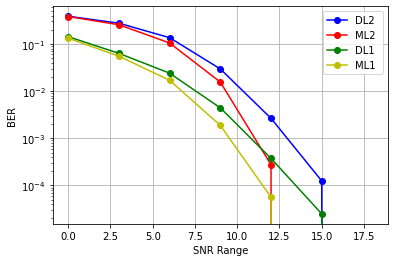

In [79]:
def frange(x,y,jump):
    while x < y:
        yield x
        x +=jump

EbNodB_range = list(frange(0,21,3))
BER1 = [None]*len(EbNodB_range)
BER2 = [None]*len(EbNodB_range)


with tf.Session() as sess:
  #Training
    sess.run(init)
    for epoch in range(traing_epochs):
        avg_cost = 0
        for index_m in range(total_batch):
            input_samples = []
            input_samples1 = []
            input_labels  = []
            input_labels1 = []
            

            
            for index_k in range(0, batch_size):
                bits1 = np.random.binomial(n=1,p=0.5,size=(q,))
                bits2 = np.random.binomial(n=1,p=0.5,size=(q,))
                signaloutput,y_con = SC_IM_NO_train(bits1,bits2,8)
                input_samples.append(signaloutput)
                input_samples1.append(y_con)
                input_labels.append(bits2)
                input_labels1.append(bits1)
                

            batch_1 = np.asarray(input_samples)
            batch_2 = np.asarray(input_labels)
            batch_3 = np.asarray(input_labels1)
            batch_4 = np.asarray(input_samples1)
            
           
            
            

            _,cs = sess.run([optimizer,cost], feed_dict={X:batch_1,Xa:batch_4,
                                                        Y1:batch_2,Y2:batch_3,
                                                        learning_rate:l_rate})
            avg_cost += cs / total_batch
        if epoch % display_step == 0:
            print("Epoch:",'%04d' % (epoch+1), "cost=", \
               "{:.9f}".format(avg_cost))
  #==========Testing=============
    for n in range(0,len(EbNodB_range)):
      input_samples_test = []
      input_samples1_test = []
      input_labels_test = []
      input_labels1_test = []
      
      test_number = 10000
      if n>10:
        test_number = 10000
      for i in range(0, test_number):
        bits1 = np.random.binomial(n=1, p=0.5, size=(q, )) 
        bits2 = np.random.binomial(n=1, p=0.5, size=(q, ))
        signaloutput,y_con = SC_IM_NO_train(bits1,bits2,EbNodB_range[n])
        input_samples_test.append(signaloutput)
        input_samples1_test.append(y_con)
        input_labels_test.append(bits2)
        input_labels1_test.append(bits1)
       
               

      batch_1 = np.asarray(input_samples_test)
      batch_2 = np.asarray(input_labels_test)
      batch_3 = np.asarray(input_labels1_test)
      batch_4 = np.asarray(input_samples1_test)
      
      mean_error_rate1 = 1-tf.reduce_mean(tf.reduce_mean(tf.to_float(tf.equal(tf.sign(y_pred-0.5), tf.cast(tf.sign(batch_3-0.5),tf.float32))),1))
      BER1[n]  = mean_error_rate1.eval({X:batch_1,Y2:batch_3})
      print("SNR1=", EbNodB_range[n], "BER1:", BER1[n])
      
      mean_error_rate2 = 1-tf.reduce_mean(tf.reduce_mean(tf.to_float(tf.equal(tf.sign(y2_pred-0.5), tf.cast(tf.sign(batch_2-0.5),tf.float32))),1))
      BER2[n]  = mean_error_rate2.eval({X:batch_1,Xa:batch_4,Y1:batch_2,Y2:batch_3})
      print("SNR2=", EbNodB_range[n], "BER2:", BER2[n])
    ML1=[0.133100000000000,	0.0551562500000000,	0.0170187500000000,	0.00188125000000000,	5.62500000000000e-05,	0,	0]
    ML2=[0.382100000000000,	0.255943750000000,	0.105200000000000	,0.0155937500000000	,0.000275000000000000,	0,	0]
    import matplotlib.pyplot as plt
    plt.plot(EbNodB_range, BER2, 'bo-',label='DL2 ')
    plt.plot(EbNodB_range, ML2, 'ro-',label='ML2 ')
    plt.plot(EbNodB_range, BER1, 'go-',label='DL1 ')
    plt.plot(EbNodB_range, ML1, 'yo-',label='ML1 ')
    #plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
    plt.yscale('log')
    plt.xlabel('SNR Range')
    plt.ylabel('BER')
    plt.grid()
    plt.legend(loc='upper right',ncol = 1)
    #plt.savefig('DL_Detection_IM_BER_matplotlib')
    plt.show()